In [ ]:
import pandas as pd
file_path = '/Stock Price Amazon-1.csv'
data = pd.read_csv(file_path)
print(data.head())

        Date       Open       High        Low      Close  Adj Close     Volume
0   1/7/2019  80.115501  83.830498  79.459503  82.028000  82.028000  688346000
1  1/14/2019  80.750000  85.809998  79.757500  84.809998  84.809998  572014000
2  1/21/2019  84.050003  84.174004  80.510002  83.528503  83.528503  413556000
3  1/28/2019  82.179497  86.820503  79.536003  81.311501  81.311501  753416000
4   2/4/2019  81.150002  83.612999  78.337997  79.411003  79.411003  472124000


In [ ]:
pip install tsfresh

In [ ]:
import json
import pandas as pd
from datetime import datetime
from tsfresh import extract_features

# Load JSON data from file
json_file_path = '/amazon.json'
with open(json_file_path, 'r') as json_file:
    json_data = json.load(json_file)

# Extract relevant data from JSON
result_data = json_data['esgChart']['result']
data_list = []

# Create a unique identifier for each time series
time_series_counter = 1

for item in result_data:
    peer_group = item['peerGroup']
    for series_type in ['symbolSeries', 'peerSeries']:
        series = item[series_type]
        for i in range(len(series['timestamp'])):
            timestamp = series['timestamp'][i]
            esg_score = series['esgScore'][i]
            governance_score = series['governanceScore'][i]
            environment_score = series['environmentScore'][i]
            social_score = series['socialScore'][i]

            data_list.append({
                'TimeSeriesID': time_series_counter,  # Synthetic identifier
                'PeerGroup': peer_group,
                'Timestamp': timestamp,
                'ESGScore': esg_score,
                'GovernanceScore': governance_score,
                'EnvironmentScore': environment_score,
                'SocialScore': social_score,
                'SeriesType': series_type
            })
            time_series_counter += 1

# Create a DataFrame from the collected data
amazon_esg = pd.DataFrame(data_list)

# Convert timestamp to datetime and reorganize columns
amazon_esg['Date'] = amazon_esg['Timestamp'].apply(lambda unix_timestamp: datetime.utcfromtimestamp(unix_timestamp))
amazon_esg.drop(columns=['Timestamp'], inplace=True)
column_order = ['TimeSeriesID', 'Date'] + [col for col in amazon_esg.columns if col not in ['TimeSeriesID', 'Date']]
amazon_esg = amazon_esg[column_order]

# Remove rows with missing values
amazon_esg_cleaned = amazon_esg.dropna()

# Filter data based on date range
start_date = '2019-08-14'
end_date = '2023-08-11'
amazon_esg = amazon_esg.loc[(amazon_esg['Date'] >= start_date) & (amazon_esg['Date'] <= end_date)]
amazon_esg.reset_index(drop=True, inplace=True)

# Remove unnecessary columns
amazon_esg.drop(columns=['PeerGroup', 'SeriesType'], inplace=True)

# Handle missing values in 'ESGScore' column
amazon_esg.dropna(subset=['ESGScore'], inplace=True)

# Extract time series features using tsfresh
extracted_features = extract_features(amazon_esg, column_id='TimeSeriesID', column_sort='Date')

# Display information about the extracted features
print(extracted_features.info())
print(extracted_features.head())
print(extracted_features.dtypes)


Feature Extraction: 100%|██████████| 148/148 [00:11<00:00, 13.24it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 61 to 192
Columns: 3132 entries, ESGScore__variance_larger_than_standard_deviation to SocialScore__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(3132)
memory usage: 905.6 KB
None
    ESGScore__variance_larger_than_standard_deviation  \
61                                                0.0   
62                                                0.0   
63                                                0.0   
64                                                0.0   
65                                                0.0   

    ESGScore__has_duplicate_max  ESGScore__has_duplicate_min  \
61                          0.0                          0.0   
62                          0.0                          0.0   
63                          0.0                          0.0   
64                          0.0                          0.0   
65                          0.0                          0.0   

    ESGScore__has_dup

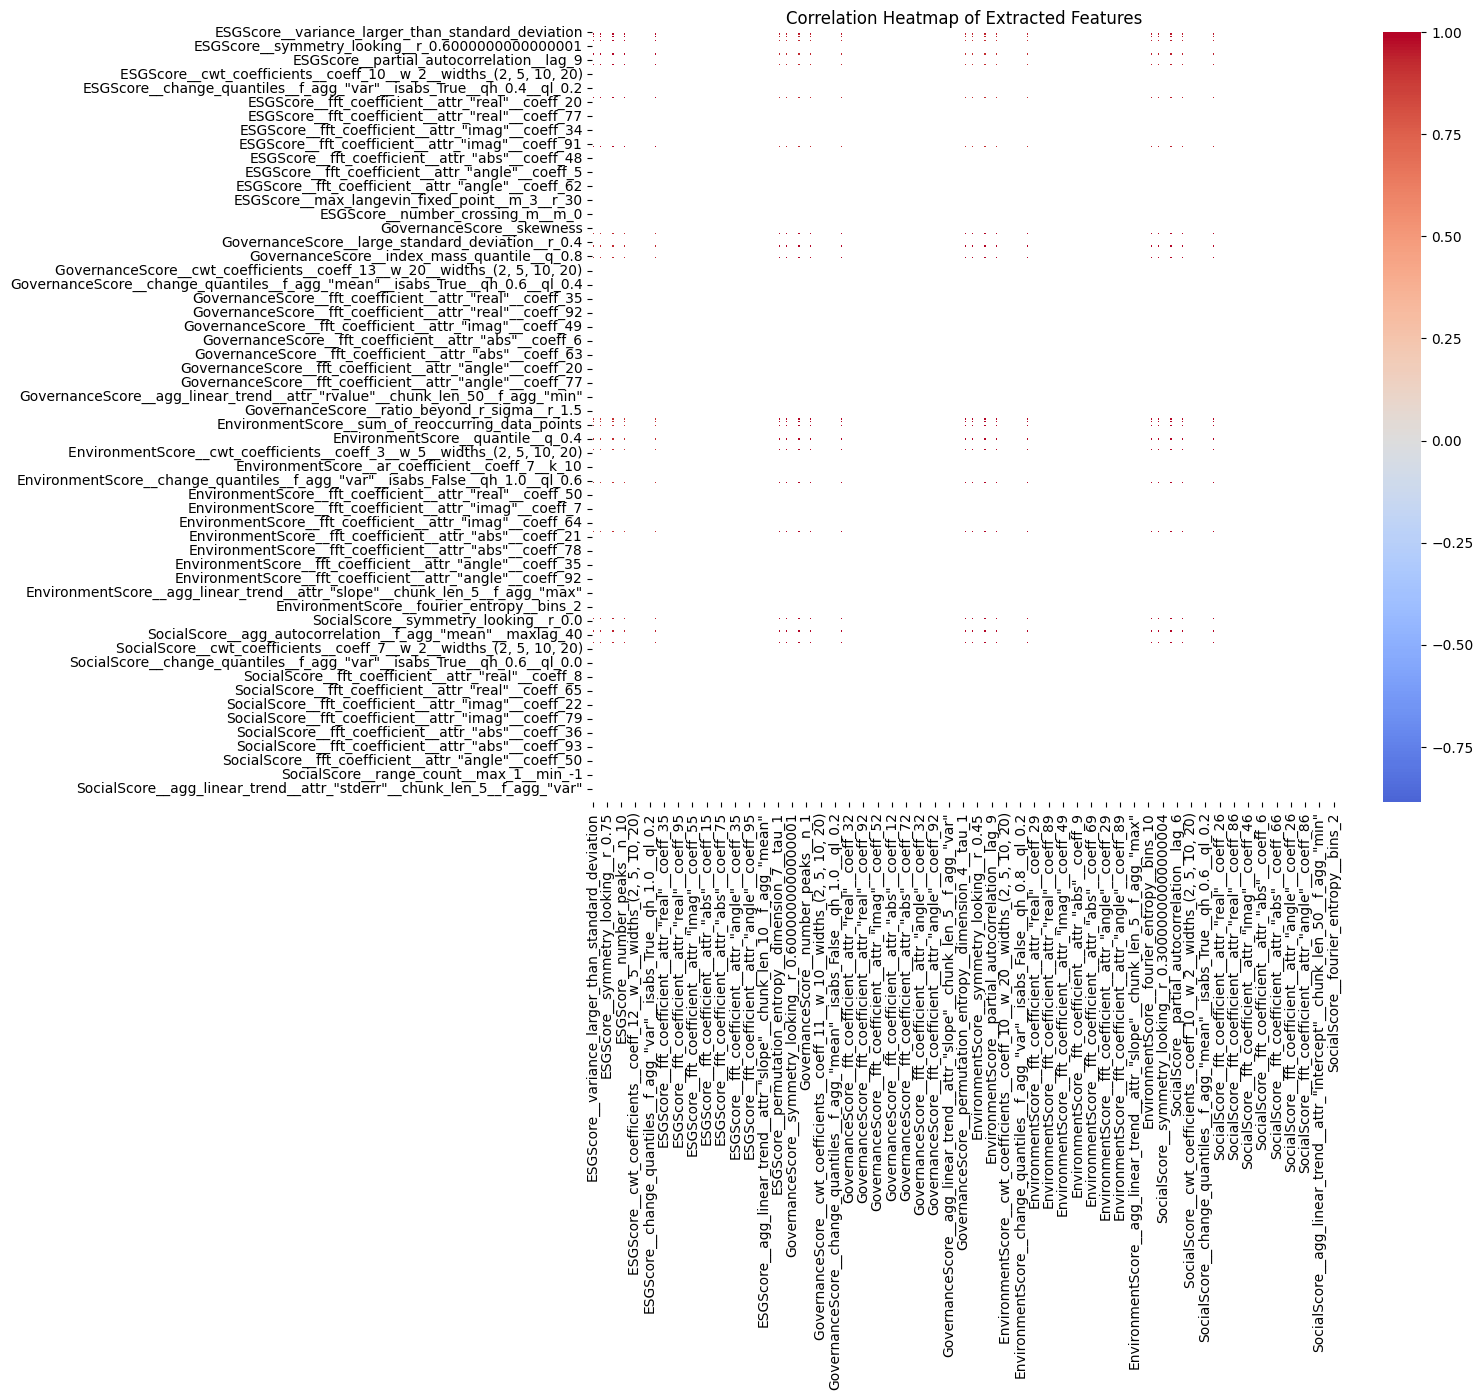

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = extracted_features.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of Extracted Features')
plt.show()


#Time Series Forecasting with ARIMA:

In [ ]:
import json
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load JSON data from a file or API response
with open('/amazon.json', 'r') as json_file:
    data = json.load(json_file)

# Extract timestamps and ESG scores
timestamps = data['esgChart']['result'][0]['peerSeries']['timestamp']
esg_scores = data['esgChart']['result'][0]['peerSeries']['esgScore']

# Create a pandas DataFrame
df = pd.DataFrame({'timestamp': timestamps, 'esg_score': esg_scores})
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Fit ARIMA model
model = ARIMA(df['esg_score'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast future values
forecast_steps = 10  # Number of steps to forecast
forecast, stderr, conf_int = model_fit.get_forecast(steps=forecast_steps).predicted_mean, model_fit.get_forecast(steps=forecast_steps).se_mean, model_fit.get_forecast(steps=forecast_steps).conf_int()

print("Forecasted ESG Scores:")
print(forecast)
print("Standard Errors:")
print(stderr)
print("Confidence Intervals:")
print(conf_int)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecasted ESG Scores:
2022-09-01    16.170298
2022-10-01    16.172308
2022-11-01    16.173236
2022-12-01    16.176760
2023-01-01    16.178655
2023-02-01    16.178725
2023-03-01    16.178733
2023-04-01    16.178686
2023-05-01    16.178553
2023-06-01    16.178507
Freq: MS, Name: predicted_mean, dtype: float64
Standard Errors:
2022-09-01     3.721262
2022-10-01     5.578975
2022-11-01     6.848177
2022-12-01     7.987661
2023-01-01     8.943172
2023-02-01     9.763447
2023-03-01    10.521026
2023-04-01    11.227692
2023-05-01    11.890732
2023-06-01    12.520318
Freq: MS, Name: var_pred_mean, dtype: float64
Confidence Intervals:
            lower esg_score  upper esg_score
2022-09-01         8.876758        23.463838
2022-10-01         5.237719        27.106898
2022-11-01         2.751056        29.595416
2022-12-01         0.521232        31.832288
2023-01-01        -1.349640        33.706949
2023-02-01        -2.957280        35.314730
2023-03-01        -4.442100        36.799565
2023-

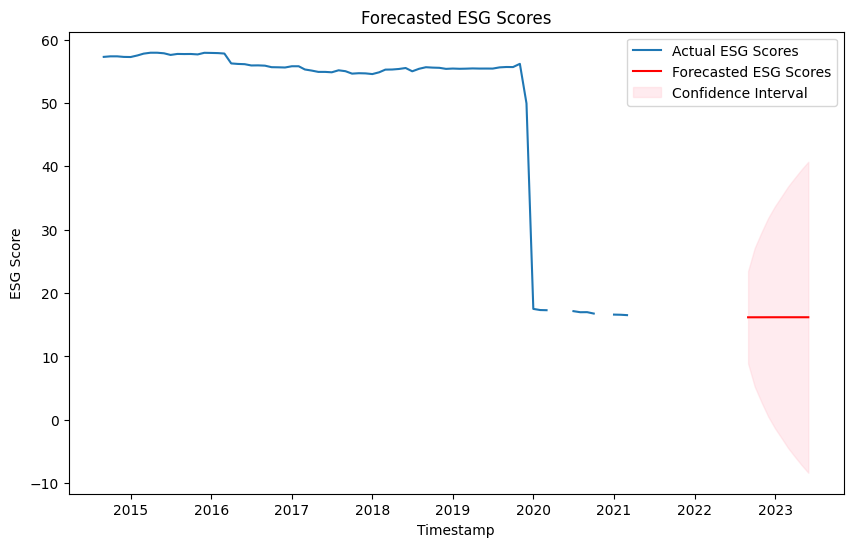

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['esg_score'], label='Actual ESG Scores')
plt.plot(forecast.index, forecast, label='Forecasted ESG Scores', color='red')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Timestamp')
plt.ylabel('ESG Score')
plt.title('Forecasted ESG Scores')
plt.legend()
plt.show()

#Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load JSON data and preprocess as before

# Split data into train and test sets
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Create features (timestamps as days since the start)
train_data['days_since_start'] = (train_data.index - train_data.index.min()).days
test_data['days_since_start'] = (test_data.index - train_data.index.min()).days

# Handle missing values
train_data.dropna(inplace=True)  # Drop rows with missing values in the training set
test_data.dropna(inplace=True)   # Drop rows with missing values in the test set

X_train = train_data[['days_since_start']]
y_train = train_data['esg_score']

X_test = test_data[['days_since_start']]
y_test = test_data['esg_score']

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

print("Predicted ESG Scores:")
print(predictions)


Predicted ESG Scores:
[38.466871   38.12551239 37.81718849 37.14548285 35.79106    34.10629011
 33.12626057 32.11319632]


<ipython-input-59-2abc77bd0353>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['days_since_start'] = (train_data.index - train_data.index.min()).days
<ipython-input-59-2abc77bd0353>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['days_since_start'] = (test_data.index - train_data.index.min()).days
<ipython-input-59-2abc77bd0353>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

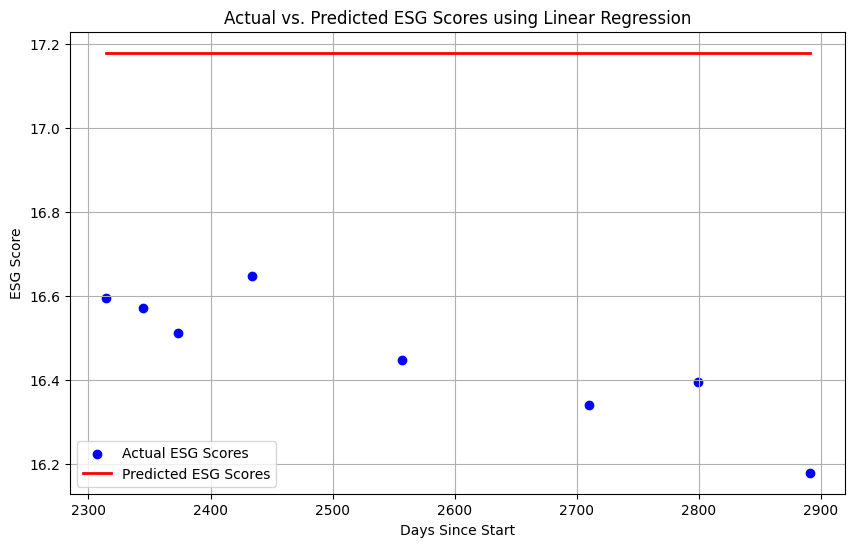

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual ESG Scores')
plt.plot(X_test, predictions, color='red', linewidth=2, label='Predicted ESG Scores')
plt.xlabel('Days Since Start')
plt.ylabel('ESG Score')
plt.title('Actual vs. Predicted ESG Scores using Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

#Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Load JSON data and preprocess as before

# Train random forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

print("Predicted ESG Scores:")
print(predictions)


Predicted ESG Scores:
[17.17885315 17.17885315 17.17885315 17.17885315 17.17885315 17.17885315
 17.17885315 17.17885315]


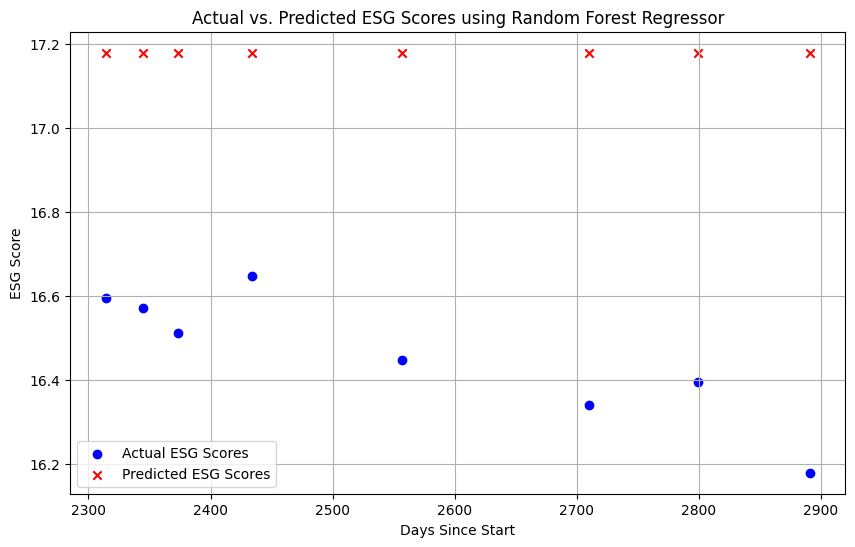

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual ESG Scores')
plt.scatter(X_test, predictions, color='red', label='Predicted ESG Scores', marker='x')
plt.xlabel('Days Since Start')
plt.ylabel('ESG Score')
plt.title('Actual vs. Predicted ESG Scores using Random Forest Regressor')
plt.legend()
plt.grid(True)
plt.show()